# Calculate ECS in CMIP6 models
## Goal: Use Gregory regression to calculate ECS $\Delta T$ [Gregory et al 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018747) 

### Using the first member of abrupt-4xCO2 simulations available on the [CMIP analysis platform](https://www2.cisl.ucar.edu/resources/cmip-analysis-platform)

## Potentially useful utilities to get the pathnames 

### get areacella the cheaty way for most models (from manually downloaded files and, when that fails, brute force $d\phi *cos(\phi)$)

In [2]:
import sys
import os
import datetime

%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
def getendpath(pathtovar,var):
    # basedir/institution/model/experiment/variant/Amon/"+variable / gridlabel / version {latest/vDATE} 
    # we begin from here:  basedir/institution/model/experiment/variant/Amon/variable/ 
    # the next level is the gridlabel
    gridlabel=os.listdir(pathtovar)
    extrabit = False
    # the next level is the version. options are: 'latest' or 'vYYYYMMDD'; sometimes there's a red herring something called 'files' 
    possible_versions = os.listdir(pathtovar+"/"+gridlabel[0])
    versions = []
    # get rid of folders that don't have netcdf files
    for aversion in possible_versions:
        files = os.listdir(pathtovar+"/"+gridlabel[0]+"/"+aversion)
        #print(aversion)
        #print(files)
        ncfiles = [item for item in files if item.endswith('.nc')]
        if len(ncfiles)>0:
            versions.append(aversion)
    if len(versions)==0:
        # try again with the variable name appended. models other than CESM have this.
        for aversion in possible_versions:
            files = os.listdir(pathtovar+"/"+gridlabel[0]+"/"+aversion+"/"+var)
            #print(aversion)
            #print(files)
            ncfiles = [item for item in files if item.endswith('.nc')]
            if len(ncfiles)>0:
                versions.append(aversion)
                extrabit = True
    #print(len(versions))
    if len(versions)==1:
        # if there's only one folder, this is easy
        theendpath = "/"+gridlabel[0]+"/"+versions[0]+"/"
    elif len(versions)==0:
        # nothing made the cut, return empty string
        theendpath = []
    else:
        # there are multiple possibilities
        # if one of them is "latest", we'll take it
        hasLatest = any(elem == 'latest' for elem in versions)
        if hasLatest:
            theendpath = "/"+gridlabel[0]+"/"+'latest'+"/"
        else:
            # if there's no latest, there should be folders of the form 'vYYYYMMDD'. 
            datevs = [item for item in versions if item.startswith('v')]
            if len(datevs)==1:
                # there was only one properly formatted folder - get it
                theendpath = "/"+gridlabel[0]+"/"+datevs[0]+"/"
            elif len(datevs)>1:
                # there are multiple dated versions. 
                # sort and take the most recent one
                datelist = [datetime.datetime.strptime(item[1:],'%Y%m%d') for item in versions]
                datelist.sort(reverse=True)
                latestversion='v'+datelist[0].strftime('%Y%m%d')
                theendpath = "/"+gridlabel[0]+"/"+latestversion+"/"
            else:
                # something went wrong; give up
                theendpath = []
    return theendpath,extrabit

In [4]:
def getvariants(pathtoexp,var):
    variants = []
    endpaths = [] 
    extrabit = []
    for variant in os.listdir(pathtoexp):
        try: 
            # check that there is actually a path for this particular variable in this experiment
            os.listdir(pathtoexp+variant+"/Amon/"+var)
            #print(variant)
            # we will now call a function that gets the end path. this is not trivial; it includes the grid label and finding the latest version. 
            thispath = pathtoexp+variant+"/Amon/"+var
            #print(thispath)
            thisendpath,extrabit = getendpath(thispath,var)
            # if this all worked, then add the variant / ensemble member, and its path info, to the list of existing ones
            if len(thisendpath)>0:
                endpaths.append(thisendpath)
                variants.append(variant)
        except:
            # in case there is not actually any data for this model + variant / ensemble member
            #print(pathtoexp+" "+variant+" is missing")
            pass
    #print(variants)
    return variants,endpaths,extrabit

In [5]:
def getOneModelExperimentVar(model,experiment,var):
    basedir = '/glade/collections/cmip/CMIP6/CMIP/'
    thisModelExpVar = []
    institutions = []
    for institution in os.listdir(basedir):
        #print(institution)
        models = os.listdir(basedir+institution)
        hasmodel = any(elem == model for elem in models)
        if hasmodel:
            institutions.append(institution)        
    if len(institutions)==1:
        institution = institutions[0]
        exps = os.listdir(basedir+institution+"/"+model)
        hasexp = any(elem == experiment for elem in exps)
        if (hasexp) : 
            # get ensemble members with data and also their end paths
            variants,endpaths,extrabit = getvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
            if len(variants)>0:
                thisModelExpVar = ModelExpVar(model,experiment,var,basedir+institution+"/"+model,variants,endpaths,extrabit)
    elif len(institutions)>1:
        print("Multiple institutions, same model")
        print(institutions)
    return thisModelExpVar

In [6]:
def globalannualmean(aModelExpVar,areacella,imem):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    ds = xr.open_mfdataset(aModelExpVar.files[imem])
    it = ds.get(aModelExpVar.variable)
    itGm=(np.tile(weight,[len(ds.time),1,1])*it).sum(dim=('lat','lon'))
    itGm_annual = itGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
    return itGm_annual


In [7]:
def climglobalmean(aModelExpVar,areacella,imem):
    weight= areacella / areacella.sum(dim=('lon','lat'))
    weight.sum(dim=('lon','lat'))
    ds = xr.open_mfdataset(aModelExpVar.files[imem])
    endtimes = ds.time[-(12*30):]
    #print(aModelExpVar.variable)
    it = ds.get(aModelExpVar.variable)
    it_c=it.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
    itGm_c=(it_c*weight).sum(dim=('lat','lon'))
    return itGm_c


In [8]:
def getChangeTimeseries(model,var,imem,areacella):
    v4x = getOneModelExperimentVar(model,"abrupt-4xCO2",var)
    vpi = getOneModelExperimentVar(model,"piControl",var)
    vGAm = globalannualmean(v4x,areacella,0)
    vpi_c = climglobalmean(vpi,areacella,0)
    change = vGAm-vpi_c
    return change

In [21]:
def getModelsForExperimentVar(experiment,var):
    basedir = '/glade/collections/cmip/CMIP6/CMIP/'
    evd_ofmodels = {}
    for institution in os.listdir(basedir):
        #print(institution)
        for model in os.listdir(basedir+institution):
            #print(institution+"/"+model)
            exps = os.listdir(basedir+institution+"/"+model)
            #print(exps)
            hasexp = any(elem == experiment for elem in exps)
            if (hasexp) : 
                # get ensemble members with data and also their end paths
                variants,endpaths,extrabit = getvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
                if len(variants)>0:
                    evd_ofmodels[model] = ModelExpVar(model,experiment,var,basedir+institution+"/"+model,variants,endpaths,extrabit)

    return evd_ofmodels

In [23]:
def keepModelsWithAllData(modeldict1,modeldict2):
    missingmodel = set(list(modeldict1)).symmetric_difference(list(modeldict2))
    for model in missingmodel:
        #print(model)
        try: 
            modeldict1.pop(model)
        except:
            pass
        try: 
            modeldict2.pop(model)
        except:
            pass
    return modeldict1,modeldict2

In [11]:
def getFXvariants(pathtoexp,var):
    variants = []
    endpaths = [] 
    extrabit = []
    for variant in os.listdir(pathtoexp):
        try: 
            # check that there is actually a path for this particular variable in this experiment
            os.listdir(pathtoexp+variant+"/fx/"+var)
            #print(variant)
            # we will now call a function that gets the end path. this is not trivial; it includes the grid label and finding the latest version. 
            thispath = pathtoexp+variant+"/fx/"+var
            #print(thispath)
            thisendpath,extrabit = getendpath(thispath,var)
            # if this all worked, then add the variant / ensemble member, and its path info, to the list of existing ones
            if len(thisendpath)>0:
                endpaths.append(thisendpath)
                variants.append(variant)
        except:
            # in case there is not actually any data for this model + variant / ensemble member
            #print(pathtoexp+" "+variant+" is missing")
            pass
    #print(variants)
    return variants,endpaths,extrabit

In [12]:
class ModelExpVar:
  def __init__(self, model, experiment, variable,startpath,variants,endpaths,extraVarFolder):
    self.model = model
    self.experiment = experiment
    self.variable = variable
    self.startpath = startpath 
    self.variants = variants
    self.endpaths = endpaths
    self.extraVarFolder = extraVarFolder    # extra folder with variable name 
    # The rest are derived
    self.nmem = len(variants)
    ## basedir/institution/model/experiment/variant/Amon/"+variable / gridlabel / version {latest/vDATE} / SOMETIMES extrafolder
    paths = []
    files = []
    for i in range(len(variants)):
        #print(variants[i])
        #print(endpaths[i])
        thepath = startpath+"/"+experiment+"/"+variants[i]+"/Amon/"+variable+endpaths[i]
        if extraVarFolder:
            thepath = thepath+variable+"/"
        paths.append(thepath)
        ensfiles = os.listdir(thepath)
        thisensfiles = []
        for file in ensfiles:
            if file.endswith(".nc"):
                # deals with duplicate files in GISS-E2-1-G
                if (model+"_"+experiment in file):  
                    thisensfiles.append(thepath+file)
        files.append(sorted(thisensfiles))
    self.paths = paths
    self.files = files

In [13]:
class ModelArea:
  def __init__(self,model,file,areacella):
    self.model = model
    self.variable = "areacella"
    self.file = file
    self.areacella = areacella
    
def getModelAreacella(model):
    basedir = "/glade/collections/cmip/CMIP6/CMIP/"
    experiment="piControl"
    var="areacella"
    thisModelExpVar = []
    institutions = []
    thisModelArea = []
    # this first method will work for CESM2. Maybe nothing else. 
    for institution in os.listdir(basedir):
        #print(institution)
        models = os.listdir(basedir+institution)
        hasmodel = any(elem == model for elem in models)
        if hasmodel:
            institutions.append(institution)        
    if len(institutions)==1:
        institution = institutions[0]
        exps = os.listdir(basedir+institution+"/"+model)
        hasexp = any(elem == experiment for elem in exps)
        if (hasexp) : 
            # get ensemble members with data and also their end paths
            variants,endpaths,extraVarFolder = getFXvariants(basedir+institution+"/"+model+"/"+experiment+"/",var)
            if len(variants)>0:
                thepath = basedir+institution+"/"+model+"/"+experiment+"/"+variants[0]+"/fx/"+var+endpaths[0]
                if extraVarFolder:
                    thepath = thepath+var+"/"
                files = os.listdir(thepath)
                thisModelArea = ModelArea(model,thepath+files[0],[])
    elif len(institutions)>1:
        print("Multiple institutions, same model")
        print(institutions)
    # If that didn't work, then we try something else. Next step is the folder with areacella files I downloaded. 
    if thisModelArea==[]:
        areacelladir="/glade/work/apgrass/pythonhackathon/areacella/"
        files = os.listdir(areacelladir)
        thefile = [item for item in files if model in item]
        #print(thefile)
        if len(thefile)>0:
            thisModelArea = ModelArea(model,areacelladir + thefile[0],[])
    if thisModelArea!=[]:
        ds = xr.open_mfdataset(thisModelArea.file)
        areacella = ds.get(thisModelArea.variable)
        thisModelArea.areacella = areacella
    else:
        # Finally, if that still didn't work, we just do lat/lon weighting. Leave it empty
        thismodeltas = getOneModelExperimentVar(model,experiment,"tas")
        ds = xr.open_mfdataset(thismodeltas.files[0][0])
        tas1time = ds.tas.sel(time=(ds.time[-1]))
        l1=np.array(tas1time.lat)
        l2=np.copy(l1)
        l2[1:]=l1[0:-1]
        l2[0]=-90
        l3=np.copy(l1)
        l3[0:-1]=l1[1:]
        l3[-1]=90
        lw = np.cos(l1*np.pi/180)*(l3-l2)
        areacella = xr.DataArray(np.transpose(np.tile(lw,[len(tas1time.lon),1])),coords = tas1time.coords, dims = tas1time.dims)
        thisModelArea = ModelArea(model,[],areacella)
    return thisModelArea

In [14]:
def calcECSts(model,imem):
    thisModelArea = getModelAreacella(model)
    dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
    drsdt = getChangeTimeseries(model,"rsdt",imem,thisModelArea.areacella)
    drsut = getChangeTimeseries(model,"rsut",imem,thisModelArea.areacella)
    drlut = getChangeTimeseries(model,"rlut",imem,thisModelArea.areacella)
    dN = drsdt - drsut - drlut
    slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
    ECS = -intercept / slope
    return ECS,intercept



In [15]:
model = "CESM2"
imem = 0
thisModelArea = getModelAreacella(model)
dts = getChangeTimeseries(model,"ts",imem,thisModelArea.areacella)
drsdt = getChangeTimeseries(model,"rsdt",imem,thisModelArea.areacella)
drsut = getChangeTimeseries(model,"rsut",imem,thisModelArea.areacella)
drlut = getChangeTimeseries(model,"rlut",imem,thisModelArea.areacella)
dN = drsdt - drsut - drlut
slope, intercept, r_value, p_value, std_err = stats.linregress(dts,dN)
cesmECS = -intercept / slope

In [17]:
print(cesmECS)
print(cesmECS/2)

10.236966252031683
5.118483126015842


In [19]:
# test: does it work for CESM2? 
cesmECS,F = calcECSts("CESM2",0)
print(cesmECS/2)

5.118483126015842


In [25]:
# Next: Make it work for CMIP6
var="ts"
ts4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
tsPi_models = getModelsForExperimentVar("piControl",var)
ts4x_models,tsPi_models = keepModelsWithAllData(ts4x_models,tsPi_models)
variables = ["rsdt","rsut","rlut"]
for var in variables:
    #print(var)
    v4x_models = getModelsForExperimentVar("abrupt-4xCO2",var)
    vPi_models = getModelsForExperimentVar("piControl",var)
    v4x_models,vPi_models = keepModelsWithAllData(v4x_models,vPi_models)
    ts4x_models,v4x_models = keepModelsWithAllData(ts4x_models,v4x_models)
list(ts4x_models)

['CNRM-CM6-1',
 'CNRM-ESM2-1',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'CESM2',
 'GISS-E2-1-H',
 'GISS-E2-1-G',
 'MRI-ESM2-0',
 'MIROC6',
 'IPSL-CM6A-LR']

In [26]:
len(ts4x_models)

10

In [27]:
ECS_models = ts4x_models

In [29]:
ECS={}
for model in list(ECS_models):
    thisECS,F = calcECSts(model,0)
    print(thisECS/2)
    ECS[model]=thisECS

5.111902690119402
4.723402408638718
2.9291486442630195
4.602931323301219
5.118483126015842
2.9529356673919844
2.5947963249497294
2.454731067981604
2.5381931479370867
2.176861477651696


In [30]:
orderedECS = sorted(ECS.items(), key=lambda x: x[1])
oECS = {}
for pair in orderedECS:
    #print(pair[0])
    #print(pair[1])
    oECS[pair[0]]=pair[1]
    
print(oECS)
oECS = { pair[0]:pair[1] for pair in orderedECS }
print(oECS)    

{'IPSL-CM6A-LR': 4.353722955303392, 'MRI-ESM2-0': 4.909462135963208, 'MIROC6': 5.0763862958741734, 'GISS-E2-1-G': 5.189592649899459, 'BCC-CSM2-MR': 5.858297288526039, 'GISS-E2-1-H': 5.905871334783969, 'CESM2-WACCM': 9.205862646602437, 'CNRM-ESM2-1': 9.446804817277435, 'CNRM-CM6-1': 10.223805380238804, 'CESM2': 10.236966252031683}
{'IPSL-CM6A-LR': 4.353722955303392, 'MRI-ESM2-0': 4.909462135963208, 'MIROC6': 5.0763862958741734, 'GISS-E2-1-G': 5.189592649899459, 'BCC-CSM2-MR': 5.858297288526039, 'GISS-E2-1-H': 5.905871334783969, 'CESM2-WACCM': 9.205862646602437, 'CNRM-ESM2-1': 9.446804817277435, 'CNRM-CM6-1': 10.223805380238804, 'CESM2': 10.236966252031683}


Text(0.5, 1.0, 'ECS for models on the CMIP analysis platform (07 Jun 2019)')

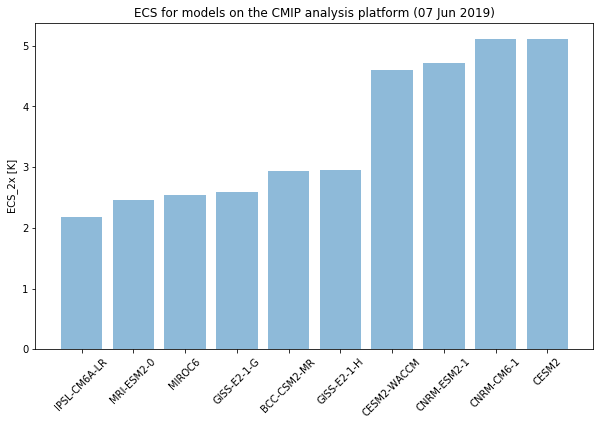

In [54]:
ecs2x = []
for val in oECS.values():
    ecs2x.append(val/2)


objects = oECS.keys()
y_pos = np.arange(len(objects))
performance = ecs2x


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=45)
plt.ylabel('ECS_2x [K]')
plt.title('ECS for models on the CMIP analysis platform ('+datetime.date.today().strftime('%d %b %Y')+')')

In [56]:
fig.savefig('cmip6-ecs.pdf')